<h1><center>Advanced Learning Techniques<center></h1>
    
**Authors** : Selma Bouchta, Emma Sarfati   
**Teacher** : Stéphan Clémençon (Télécom Paris)  
ENSAE 3rd year  
$\texttt{selma.bouchta@ensae.fr}$ ⎜ $\texttt{emma.sarfati@ensae.fr}$
<h1><center>Abstract</center></h1>
    
In this notebook, we propose an implementation of the paper from M. Lardeur , S. Essid, G. Richard, M. Haller, T. Sikora: *Incorporating prior knowledge on the digital media creation process into audio classifiers*. We will first handle a long step of feature extraction based on knowledge about audio signal processing (http://recherche.ircam.fr/anasyn/peeters/pub/cours/Peeters_2011_CNAM_1.pdf). Once the features are extracted, we create our dataframe and run state-of-the-art models and the paper main contribution, which is an adaptation of the Invariant SVM algorithm proposed by Decoste & Schölkopf (https://people.eecs.berkeley.edu/~malik/cs294/decoste-scholkopf.pdf).
    

<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Feature-extraction-" data-toc-modified-id="Feature-extraction--1">Feature extraction <a class="anchor" id="first-bullet"></a></a></span><ul class="toc-item"><li><span><a href="#Spectral-Centroid" data-toc-modified-id="Spectral-Centroid-1.1">Spectral Centroid</a></span></li><li><span><a href="#Spectral-Bandwidth" data-toc-modified-id="Spectral-Bandwidth-1.2">Spectral Bandwidth</a></span></li><li><span><a href="#Spectral-Contrast" data-toc-modified-id="Spectral-Contrast-1.3">Spectral Contrast</a></span></li><li><span><a href="#Spectral-Rolloff" data-toc-modified-id="Spectral-Rolloff-1.4">Spectral Rolloff</a></span></li><li><span><a href="#Energy" data-toc-modified-id="Energy-1.5">Energy</a></span></li><li><span><a href="#Tempogram" data-toc-modified-id="Tempogram-1.6">Tempogram</a></span></li><li><span><a href="#Statistical-moments" data-toc-modified-id="Statistical-moments-1.7">Statistical moments</a></span></li><li><span><a href="#Peaks" data-toc-modified-id="Peaks-1.8">Peaks</a></span></li><li><span><a href="#Autocorrelation" data-toc-modified-id="Autocorrelation-1.9">Autocorrelation</a></span></li><li><span><a href="#Spectral-spread" data-toc-modified-id="Spectral-spread-1.10">Spectral spread</a></span></li><li><span><a href="#Spectral-slope" data-toc-modified-id="Spectral-slope-1.11">Spectral slope</a></span></li></ul></li><li><span><a href="#Creating-the-dataframe" data-toc-modified-id="Creating-the-dataframe-2">Creating the dataframe</a></span></li><li><span><a href="#Support-Vector-Machines" data-toc-modified-id="Support-Vector-Machines-3">Support Vector Machines</a></span><ul class="toc-item"><li><span><a href="#Classic-SVM" data-toc-modified-id="Classic-SVM-3.1">Classic SVM</a></span></li><li><span><a href="#Transformation" data-toc-modified-id="Transformation-3.2">Transformation</a></span></li><li><span><a href="#Paper-contribution:-VASVM" data-toc-modified-id="Paper-contribution:-VASVM-3.3">Paper contribution: VASVM</a></span></li></ul></li></ul></div>

We used the IRMAS dataset : a dataset for instrument recognition in musical audio signals

## Feature extraction <a class="anchor" id="first-bullet"></a>

The goal is to extract as much relevant features as possible from the dataset. To do so, we explore the audios and try to find variables to add to a dataframe.

To run the following, you need to install `sox` on your device through:
    `brew install sox` 


In [1]:
import librosa
import pandas as pd
import numpy as np
import pylab
from scipy.io import wavfile
from scipy.fftpack import fft
import matplotlib.pyplot as plt
%matplotlib inline
import os
import csv
from scipy import signal
from scipy.fft import fftshift
# Preprocessing
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler, minmax_scale
import scipy
import sox
from tqdm.notebook import tqdm

We start by visualizing two examples from the Training dataset, one song of a violin and the other of a saxophone.

In [2]:
songname = '/Users/emmasarfati/Techniques Avancées/instruments/Training/sax/118__[sax][nod][jaz_blu]1702__3.wav'
y, sr = librosa.load(songname, mono=True, duration=30)

songname2 = '/Users/emmasarfati/Techniques Avancées/instruments/Training/vio/001__[vio][nod][cou_fol]2194__1.wav'
z, sr2 = librosa.load(songname2, mono=True, duration=30)

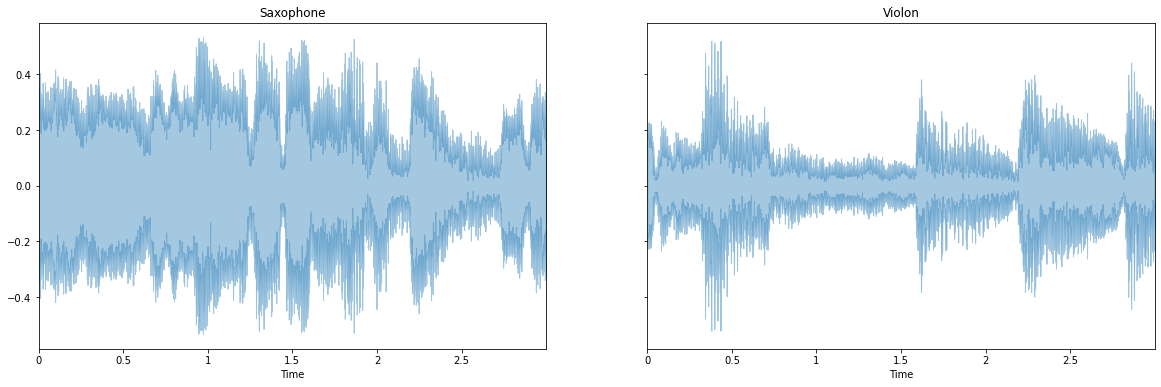

In [3]:
from librosa import display

#Plot the amplitude envelope of a waveform.
fig, axes = plt.subplots(1, 2, figsize=(20,6), sharey=True)
librosa.display.waveplot(y, sr=sr, alpha=0.4, ax=axes[0])
librosa.display.waveplot(z, sr=sr2, alpha=0.4, ax=axes[1])
axes[0].set_title('Saxophone')
axes[1].set_title('Violon')
plt.show()

We compute the spectrum and visualize it :

$$
X(k)=\sum_{n=0}^{N-1} x(n) \exp \left(j 2 \pi \frac{k}{N} n\right) \,\,\,\forall k \in[0, N]
$$

To get the spectrum we first need to compute the frequencies from amplitude and time using FFT, Fast Fourier Transform algorithm.

In [4]:
#Function that computes the frequency array
def freqarray(song):
        
    #Read file and get sampling frequency and sound object
    samplingFreq, mySound = wavfile.read(song)
    
    #Convert our sound array to floating point values ranging from -1 to 1
    mySound = mySound / (2.**15)
    
    #Get the length of mySound
    mySoundLength = len(mySound)

    #Take the Fourier transformation on given sample point 
    fftArray = fft(mySound[:,0])

    numUniquePoints = int(np.ceil((mySoundLength + 1) / 2.0))
    fftArray = fftArray[0:numUniquePoints]

    #FFT contains both magnitude and phase and given in complex numbers in real + imaginary parts (a + ib) format.
    #By taking absolute value , we get only real part
    fftArray = abs(fftArray)

    #Scale the fft array by length of sample points 
    #This allows the magnitude to not depend on the length of the signal or on its sampling frequency
    fftArray = fftArray / float(mySoundLength)

    #FFT has both positive and negative information. Square to get positive only
    fftArray = fftArray **2

    #Multiply by two
    #Odd NFFT excludes Nyquist point
    if mySoundLength % 2 > 0: #we've got odd number of points in fft
        fftArray[1:len(fftArray)] = fftArray[1:len(fftArray)] * 2

    else: #We've got even number of points in fft
        fftArray[1:len(fftArray) -1] = fftArray[1:len(fftArray) -1] * 2  

    freqArray = np.arange(0, numUniquePoints, 1.0) * (samplingFreq / mySoundLength)
    
    return(freqArray, fftArray)

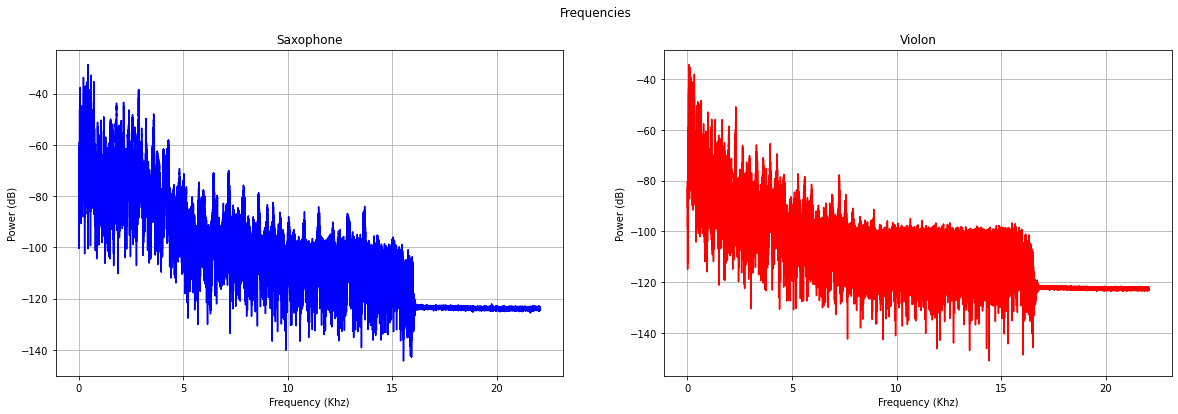

In [5]:
#Plot the frequency for both examples

FreqArray, fftArray = freqarray(songname)
FreqArray2, fftArray2 = freqarray(songname2)
fig, axes = plt.subplots(1,2,figsize=(20,6))
axes[0].plot(FreqArray/1000, 10 * np.log10 (fftArray), color='b')
axes[0].set_xlabel('Frequency (Khz)')
axes[0].set_ylabel('Power (dB)')
axes[0].grid()
axes[0].set_title('Saxophone')
axes[1].plot(FreqArray2/1000, 10 * np.log10 (fftArray2), color='r')
axes[1].set_xlabel('Frequency (Khz)')
axes[1].set_ylabel('Power (dB)')
axes[1].grid()
axes[1].set_title('Violon')

plt.suptitle('Frequencies')
plt.show()

We can now create a function that computes the spectrum. This function will be very usefull for the feature extraction.

In [6]:
def spectrum(song):
    FreqArray, fftArray = freqarray(song)
    return  10 * np.log10 (fftArray)

In [7]:
spectrum(songname)

array([ -96.29402173,  -96.12704076,  -87.29806538, ..., -124.04086349,
       -123.34746228, -123.61230512])

In [8]:
spectrum(songname2)

array([ -98.15343175,  -82.67814116,  -80.42112093, ..., -122.19350778,
       -122.6197978 , -122.91690186])

### Spectral Centroid

The spectral centroid is a measure that indicates where the center of mass of the spectrum is located. It is calculated as the weighted mean of the frequencies present in the signal, determined using a Fourier transform, with their magnitudes as the weights.

$$c g s=\frac{\sum_{k=1}^{N} f(k) S\left(k\right)}{\sum_{k=1}^{N} S\left(k\right)}$$
where $S(k)$ is the spectral magnitude at frequency bin $k$ and $f(k)$ is the frequency at bin $k$.

In [9]:
#Compute the spectral centroid for each frame in a signal
spectral_centroids = librosa.feature.spectral_centroid(y, sr=sr)[0] 
spectral_centroids2 = librosa.feature.spectral_centroid(z, sr=sr2)[0]

In [10]:
frames = range(len(spectral_centroids))
t = librosa.frames_to_time(frames)

frames2 = range(len(spectral_centroids2))
t_ = librosa.frames_to_time(frames2)

def normalize(x, axis=0):
    return minmax_scale(x, axis=axis)

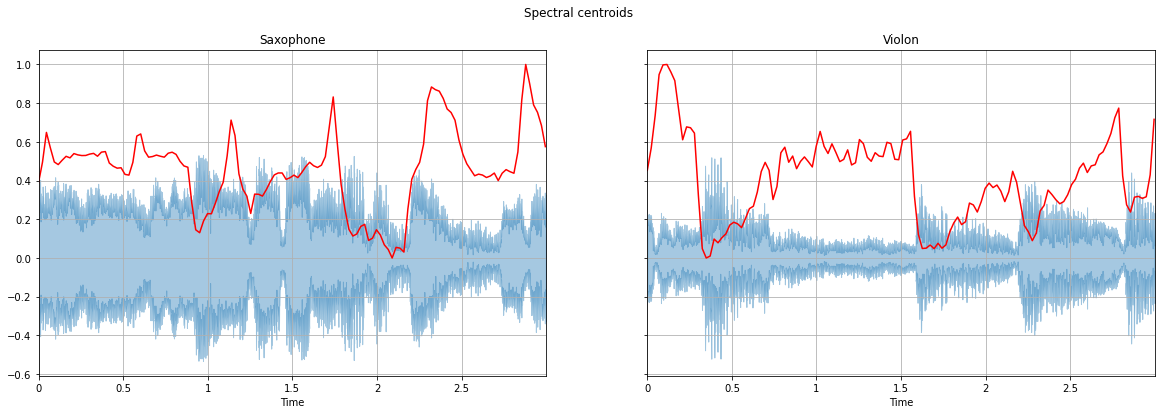

In [11]:
#Plot of the spectral centroid along with the waveform:
fig, axes = plt.subplots(1, 2, figsize=(20,6), sharey=True)
plt.suptitle('Spectral centroids')
librosa.display.waveplot(y, sr=sr, alpha=0.4, ax=axes[0])
librosa.display.waveplot(z, sr=sr2, alpha=0.4, ax=axes[1])
axes[0].plot(t, normalize(spectral_centroids), color='r') # normalize for visualization purposes
axes[0].set_title('Saxophone')
axes[0].grid()
axes[1].plot(t_, normalize(spectral_centroids2), color='r') # normalize for visualization purposes
axes[1].set_title('Violon')
axes[1].grid()
plt.show()

In [12]:
def FeatureSpectralCentroid(X, f_s):

    isSpectrum = X.ndim == 1
    norm = X.sum(axis=0, keepdims=True)
    norm[norm == 0] = 1

    vsc = np.dot(np.arange(0, X.shape[0]), X) / norm

    # convert from index to Hz
    vsc = vsc / (X.shape[0] - 1) * f_s / 2

    # if input is a spectrum, output scaler else if spectrogram, output 1d array
    vsc = np.squeeze(vsc) if isSpectrum else np.squeeze(vsc, axis=0)

    return vsc

### Spectral Bandwidth

The order-p spectral Bandwith is computed through :
$$
\operatorname{B}_p=\left(\sum_{k} S(k)\left(f(k)-f_{c}\right)^{p}\right)^{\frac{1}{p}}
$$
where  $S(k)$ is the spectral magnitude at frequency bin $k$, $f(k)$ is the frequency at bin $k$, and  $f_c$ is the spectral centroid.

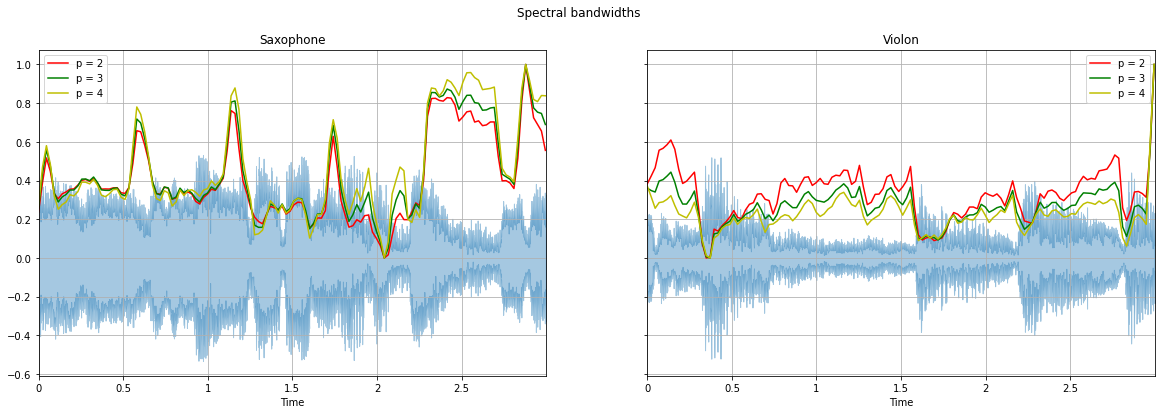

In [13]:
fig, axes = plt.subplots(1, 2, figsize=(20,6), sharey=True)

#Compute the order-p spectral bandwidth for p=2,3 and 4 for both songs                        
spectral_bandwidth_2 = librosa.feature.spectral_bandwidth(y, sr=sr)[0]
spectral_bandwidth_3 = librosa.feature.spectral_bandwidth(y, sr=sr, p=3)[0]
spectral_bandwidth_4 = librosa.feature.spectral_bandwidth(y, sr=sr, p=4)[0]

spectral_bandwidth_2_ = librosa.feature.spectral_bandwidth(z, sr=sr2)[0]
spectral_bandwidth_3_ = librosa.feature.spectral_bandwidth(z, sr=sr2, p=3)[0]
spectral_bandwidth_4_ = librosa.feature.spectral_bandwidth(z, sr=sr2, p=4)[0]

#Plot
librosa.display.waveplot(y, sr=sr, alpha=0.4, ax=axes[0])
librosa.display.waveplot(z, sr=sr2, alpha=0.4, ax=axes[1])
axes[0].plot(t, normalize(spectral_bandwidth_2), color='r')
axes[0].plot(t, normalize(spectral_bandwidth_3), color='g')
axes[0].plot(t, normalize(spectral_bandwidth_4), color='y')
axes[0].set_title('Saxophone')
axes[0].grid()
axes[0].legend(('p = 2', 'p = 3', 'p = 4'))

axes[1].plot(t_, normalize(spectral_bandwidth_2_), color='r')
axes[1].plot(t_, normalize(spectral_bandwidth_3_), color='g')
axes[1].plot(t_, normalize(spectral_bandwidth_4_), color='y')
axes[1].set_title('Violon')
axes[1].grid()
axes[1].legend(('p = 2', 'p = 3', 'p = 4'))

plt.suptitle('Spectral bandwidths')
plt.show()

### Spectral Contrast

Spectral contrast considers the spectral peak, the spectral valley, and their difference in each frequency subband.

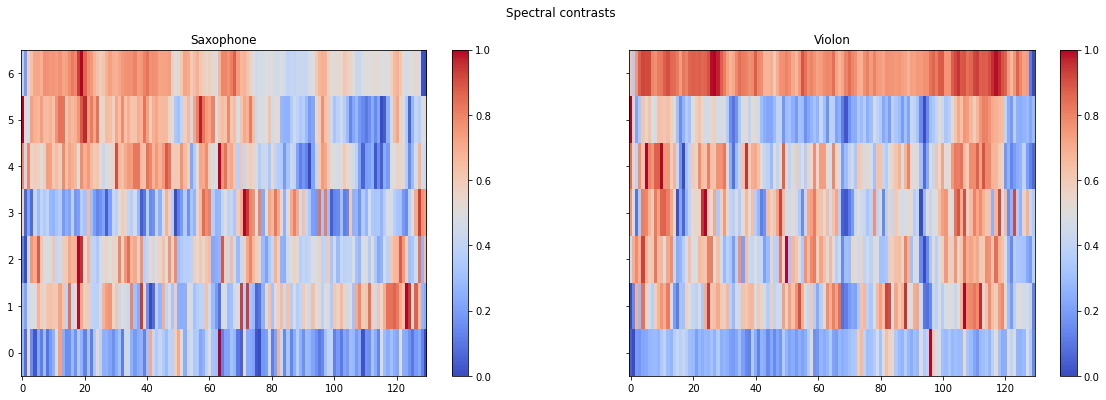

In [14]:
fig, axes = plt.subplots(1, 2, figsize=(20,6), sharey=True)

#Computes the spectral contrast for six subbands for each time frame
spectral_contrast = librosa.feature.spectral_contrast(y, sr=sr)
spectral_contrast_ = librosa.feature.spectral_contrast(z, sr=sr2)

#Plot
axes[0].set_title('Saxophone')
axes[1].set_title('Violon')
fig1 = axes[0].imshow(normalize(spectral_contrast, axis=1), aspect='auto', origin='lower', cmap='coolwarm')
fig2 = axes[1].imshow(normalize(spectral_contrast_, axis=1), aspect='auto', origin='lower', cmap='coolwarm')
plt.suptitle('Spectral contrasts')
plt.colorbar(fig1, ax=axes[0])
plt.colorbar(fig2, ax=axes[1])

plt.show()

### Spectral Rolloff

Spectral rolloff is the frequency below which a specified percentage of the total spectral energy lies. ($85$% by default)

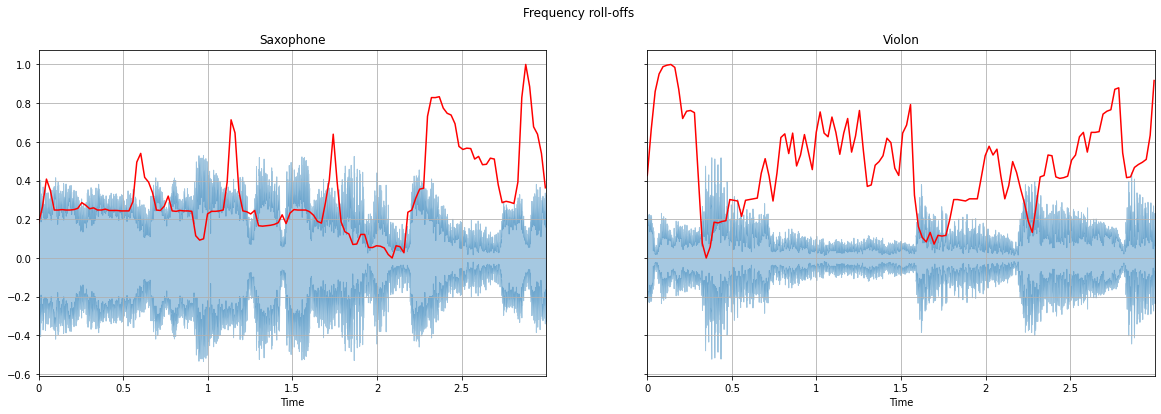

In [15]:
fig, axes = plt.subplots(1, 2, figsize=(20,6), sharey=True)
plt.suptitle('Frequency roll-offs')

#Compute the rolloff frequency for each frame in a signal
spectral_rolloff = librosa.feature.spectral_rolloff(y, sr=sr)[0]
spectral_rolloff_ = librosa.feature.spectral_rolloff(z, sr=sr2)[0]

#Plot
librosa.display.waveplot(y, sr=sr, alpha=0.4, ax=axes[0])
librosa.display.waveplot(z, sr=sr2, alpha=0.4, ax=axes[1])
axes[0].plot(t, normalize(spectral_rolloff), color='r')
axes[0].set_title('Saxophone')
axes[0].grid()
axes[1].plot(t_, normalize(spectral_rolloff_), color='r')
axes[1].set_title('Violon')
axes[1].grid()
plt.show()

### Energy

We want to convert an amplitude spectrogram into dB-scaled spectrogram to get energy levels.

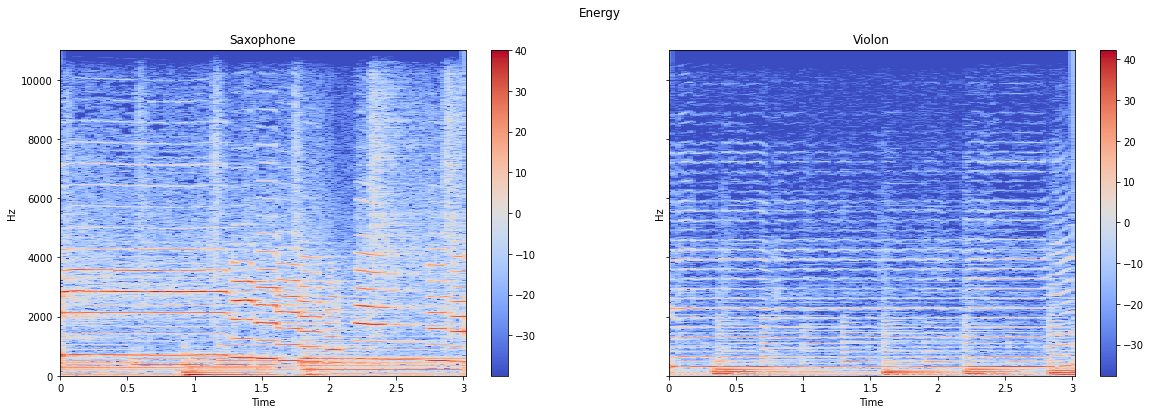

In [16]:
X = librosa.stft(y)
X_ = librosa.stft(z)

#Converting into energy levels(dB)
Xdb = librosa.amplitude_to_db(abs(X))
Xdb_ = librosa.amplitude_to_db(abs(X_))

#Plot
fig, axes = plt.subplots(1, 2, figsize=(20, 6), sharey=True)
fig1 = librosa.display.specshow(Xdb, sr=sr, x_axis='time', y_axis='hz', ax=axes[0])
fig2 = librosa.display.specshow(Xdb_, sr=sr2, x_axis='time', y_axis='hz', ax=axes[1])
axes[0].set_title('Saxophone')
axes[1].set_title('Violon')
plt.colorbar(fig1, ax=axes[0])
plt.colorbar(fig2, ax=axes[1])
plt.suptitle('Energy')

plt.show()

### Tempogram

We want to estimate the tempo (beats per minute). The tempogram is the local autocorrelation of the onset strength envelope.

In [17]:
hop_length = 512 #hop length of the time series

#Compute a spectral flux onset strength envelope.
oenv = librosa.onset.onset_strength(y=y, sr=sr, hop_length=hop_length)
oenv_ = librosa.onset.onset_strength(z, sr2, hop_length=hop_length)

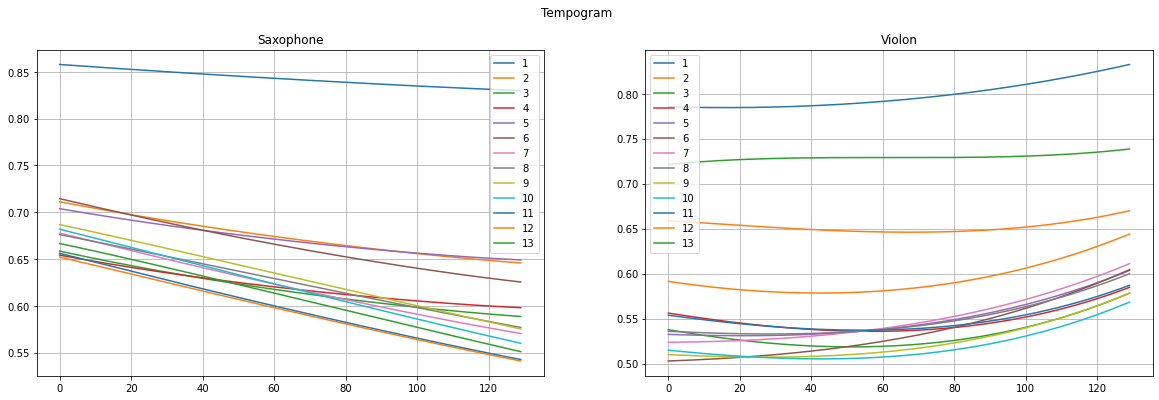

In [18]:
tempo = librosa.beat.tempo(y)[0] #Estimates the tempo (beats per minute)
tempo_ = librosa.beat.tempo(z)[0] #Estimates the tempo (beats per minute)

fig, axes = plt.subplots(1,2,figsize=(20,6))

#Compute the tempogram
tempogram = librosa.feature.tempogram(onset_envelope=oenv, sr=sr, hop_length=hop_length)
tempogram_ = librosa.feature.tempogram(onset_envelope=oenv_, sr=sr2, hop_length=hop_length)

for i in range(1,14):
    axes[0].plot(tempogram[i], label=i)
    axes[1].plot(tempogram_[i], label=i)
    
axes[0].set_title('Saxophone')
axes[0].grid()
axes[1].grid()
axes[1].set_title('Violon')
axes[0].legend()
axes[1].legend()
plt.suptitle("Tempogram")
plt.show()

### Statistical moments

We want to analyse the statistical moments of the audios through their frequencies. We compute the mean, standard deviation, maximum, minimum, median, the sample skewness, the kurtosis, Q1, Q3, the mode and the interquartile range

In [19]:
def describe_freq(x):
    
    freqs = abs(fft(x))
    mean = np.mean(freqs)
    std = np.std(freqs) 
    maxv = np.amax(freqs) 
    minv = np.amin(freqs) 
    median = np.median(freqs)
    skew = scipy.stats.skew(freqs)
    kurt = scipy.stats.kurtosis(freqs)
    q1 = np.quantile(freqs, 0.25)
    q3 = np.quantile(freqs, 0.75)
    mode = scipy.stats.mode(freqs)[0][0]
    iqr = scipy.stats.iqr(freqs)
    
    return [mean, std, maxv, minv, median, skew, kurt, q1, q3, mode, iqr]

In [20]:
describe_freq(y)

[11.90369,
 32.333603,
 851.09235,
 0.00089154014,
 2.85357,
 8.461697578430176,
 114.02830404993385,
 1.299572616815567,
 8.332518577575684,
 0.90465504,
 7.032945960760117]

In [21]:
describe_freq(z)

[4.899309,
 24.63173,
 988.4627,
 0.0024949806,
 0.7284725,
 17.64174461364746,
 448.0725918862989,
 0.25957703590393066,
 2.5489779114723206,
 0.21705067,
 2.28940087556839]

### Peaks

Our goal is to get the peaks of the audios 

In [22]:
hop_length = 256
onset_envelope = librosa.onset.onset_strength(y, sr=sr, hop_length=hop_length)
onset_envelope_ = librosa.onset.onset_strength(z, sr=sr2, hop_length=hop_length)

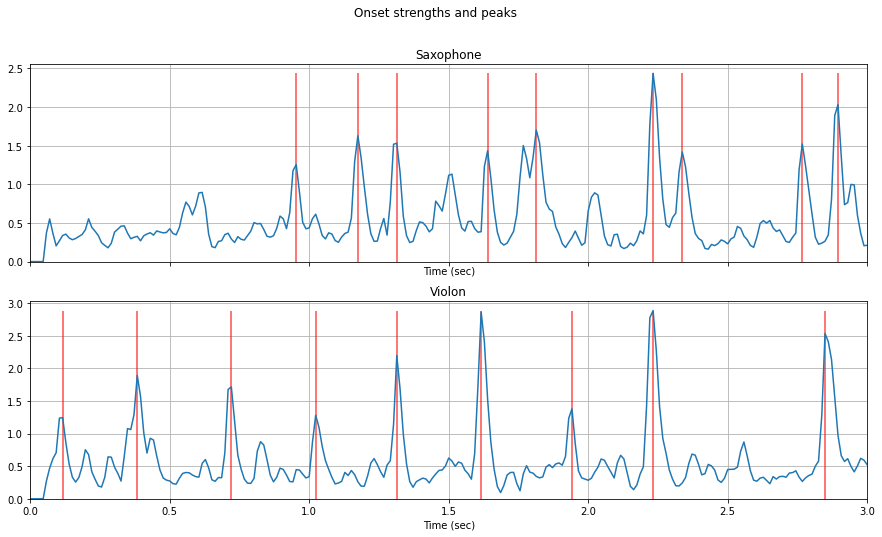

In [23]:
fig, axes = plt.subplots(2, 1, figsize=(15,8), sharex=True)

#The following function uses a flexible heuristic to pick peaks in a signal.
onset_frames = librosa.util.peak_pick(onset_envelope, 7, 7, 7, 7, 0.5, 5) 
onset_frames_ = librosa.util.peak_pick(onset_envelope_, 7, 7, 7, 7, 0.5, 5)

#Plot
plt.suptitle('Onset strengths and peaks')
N = len(y)
T = N/float(sr)
t = np.linspace(0, T, len(onset_envelope))
axes[0].plot(t, onset_envelope)
axes[0].grid()
axes[0].vlines(t[onset_frames], 0, onset_envelope.max(), color='r', alpha=0.7)
axes[0].set_xlabel('Time (sec)')
axes[0].set_xlim(0, T)
axes[0].set_ylim(0)
axes[0].set_title('Saxophone')

N_ = len(z)
T_ = N_/float(sr)
t_ = np.linspace(0, T_, len(onset_envelope_))
axes[1].plot(t_, onset_envelope_)
axes[1].grid()
axes[1].vlines(t_[onset_frames_], 0, onset_envelope_.max(), color='r', alpha=0.7)
axes[1].set_xlabel('Time (sec)')
axes[1].set_xlim(0, T_)
axes[1].set_ylim(0)
axes[1].set_title('Violon')

plt.show()

In [26]:
#Function that returns the indices of the peaks in an audio
def nb_peaks(y, hop_length = 256):
    onset_envelope = librosa.onset.onset_strength(y, sr=sr, hop_length=hop_length)
    N = len(y)
    T = N/float(sr)
    t = np.linspace(0, T, len(onset_envelope))
    onset_frames = librosa.util.peak_pick(onset_envelope, 7, 7, 7, 7, 0.5, 5)
    if len(onset_frames) != 0:
        return(onset_frames)
    else:
        return []

In [27]:
nb_peaks(y), nb_peaks(z)

(array([ 82, 101, 113, 141, 156, 192, 201, 238, 249]),
 array([ 10,  33,  62,  88, 113, 139, 167, 192, 245]))

We will use this function by counting the length of the array to get the number of peaks.

### Autocorrelation

The analysis of autocorrelation is a mathematical tool for finding repeating patterns. For musical signals, a repeated pattern can correspond to a pitch period. We can therefore use the autocorrelation function to estimate the pitch in a musical signal.

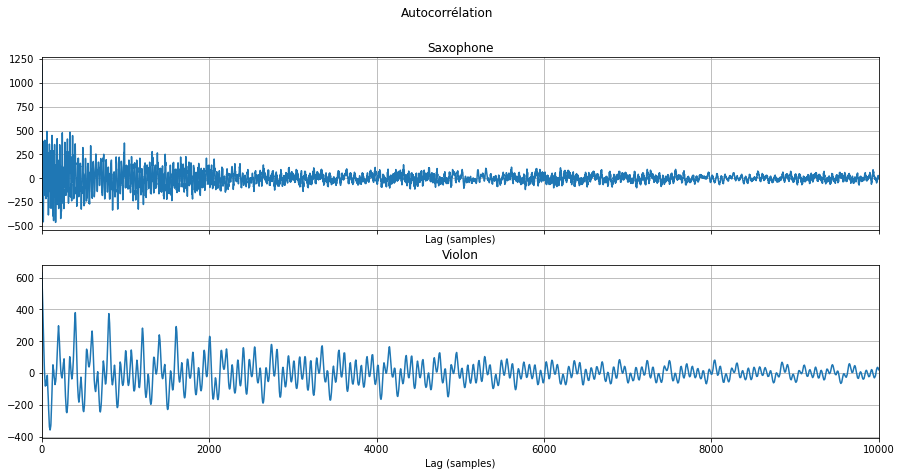

In [28]:
#Bounded auto-correlation
r = librosa.autocorrelate(y, max_size=10000)
r_ = librosa.autocorrelate(z, max_size=10000)

#Plot
fig, axes = plt.subplots(2,1,figsize=(15,7),sharex=True)
axes[0].grid()
axes[1].grid()
axes[0].plot(r)
axes[1].plot(r_)
axes[0].set_xlabel('Lag (samples)')
axes[1].set_xlabel('Lag (samples)')
axes[0].set_xlim(0, 10000)
axes[1].set_xlim(0, 10000)
axes[0].set_title('Saxophone')
axes[1].set_title('Violon')

plt.suptitle('Autocorrélation')
plt.show()

The autocorrelation always has a maximum at zero, i.e. zero lag. We want to identify the maximum outside of the peak centered at zero. Therefore, we might choose only to search within a range of reasonable pitches:

In [29]:
#Function that returns the pitch in Hertz
def pitch(y,sr):
    
    #Bounded auto-correlation
    r = librosa.autocorrelate(y, max_size=10000)
    
    #Choice of the range
    midi_hi = 80.0
    midi_lo = 10.0
    f_hi = librosa.midi_to_hz(midi_hi)
    f_lo = librosa.midi_to_hz(midi_lo)
    t_lo = sr/f_hi
    t_hi = sr/f_lo
    
    #Set invalid pitch candidates to zero
    r[:int(t_lo)] = 0
    r[int(t_hi):] = 0
    
    #Find the location of the maximum
    t_max = r.argmax()
    
    return(float(sr)/t_max) #Estimate the pitch in Hertz

In [30]:
pitch(y,sr), pitch(z,sr2)

(355.64516129032256, 54.98753117206982)

### Spectral spread 


$$
s t d=\sqrt{\frac{\sum_{k=1}^{N}\left(f(k)-c g s\right)^{2} S\left(k\right)}{\sum_{k=1}^{N} S\left(k\right)}}
$$

In [31]:
def FeatureSpectralSpread(X, f_s):

    isSpectrum = X.ndim == 1
    if isSpectrum:
        X = np.expand_dims(X, axis=1)

    #Get spectral centroid as index
    vsc = FeatureSpectralCentroid(X, f_s) * 2 / f_s * (X.shape[0] - 1)
    norm = X.sum(axis=0)
    norm[norm == 0] = 1

    #Compute spread
    vss = np.zeros(X.shape[1])
    indices = np.arange(0, X.shape[0])
    for n in range(0, X.shape[1]):
        vss[n] = np.dot((indices - vsc[n])**2, X[:, n]) / norm[n]

    vss = np.sqrt(vss)

    #Convert from index to Hz
    vss = vss / (X.shape[0] - 1) * f_s / 2

    return np.squeeze(vss) if isSpectrum else vss

### Spectral slope 

In [32]:
#Compute the spectral slope from the magnitude spectrum
def FeatureSpectralSlope(X, f_s):

    #Compute mean
    mu_x = X.mean(axis=0, keepdims=True)

    #Compute index vector
    kmu = np.arange(0, X.shape[0]) - X.shape[0] / 2

    #Compute slope
    X = X - mu_x
    vssl = np.dot(kmu, X) / np.dot(kmu, kmu)

    return vssl

## Creating the dataframe

Given the above analysis, we extract those features from the audios of the IRMAS dataset. We create a dataframe with all the features.

In [33]:
header = 'filename mean std maxv minv median skew kurt q1 q3 mode iqr tempo pitch nb_peaks spectral_flatness spectral_slope spectral_spread poly_features tonnetz melspectrogram chroma_stft rmse cqt spectral_centroid spectral_bandwidth rolloff zero_crossing_rate'
for i in range(1, 22):
    header += f' mfcc{i}'
header += ' label'
header = header.split()

WARNING : DON'T RUN THIS CELL IF YOU ALREADY HAVE THE DATAFRAME

In [146]:
####### DON'T RUN THIS CELL IF YOU ALREADY HAVE THE DATAFRAME #########

file = open('data.csv', 'w', newline='')
with file:
    writer = csv.writer(file)
    writer.writerow(header)
instruments = 'cel cla flu gac gel org pia sax tru vio voi'.split() 
for i in instruments: 
    for filename in tqdm(os.listdir(f'/Users/emmasarfati/Downloads/IRMAS-TrainingData/{i}')):
        songname = f'/Users/emmasarfati/Downloads/IRMAS-TrainingData/{i}/{filename}'
        y, sr = librosa.load(songname, mono=True, duration=30)
        
        chroma_stft = librosa.feature.chroma_stft(y=y, sr=sr)           #chromagram
        rmse = librosa.feature.rms(y=y)                                 #RMS
        cqt = librosa.cqt(y=y, sr=sr)                                   #the constant-Q transform
        spec_cent = librosa.feature.spectral_centroid(y=y, sr=sr)       #spectral centroid
        spec_cont = librosa.feature.spectral_contrast(y=y, sr=sr)       #spectral contrast
        spec_bw = librosa.feature.spectral_bandwidth(y=y, sr=sr)        #spectral bandwidth
        rolloff = librosa.feature.spectral_rolloff(y=y, sr=sr)          #spectral rolloff
        zcr = librosa.feature.zero_crossing_rate(y)                     #zero-crossing rate
        mfcc = librosa.feature.mfcc(y=y, sr=sr)                         #Mel-frequency cepstral coefficients
        spec_flat = librosa.feature.spectral_flatness(y=y)              #spectral flatness
        spec_slope = FeatureSpectralSlope(y,sr)                         #spectral slope
        spec_spread = FeatureSpectralSpread(y,sr)                       #spectral spread
        poly_feat = librosa.feature.poly_features(y=y, sr=sr)           #polynomial features
        tonnetz = librosa.feature.tonnetz(y=y, sr=sr)                   #tonal centroid features
        mel = librosa.feature.melspectrogram(y=y, sr=sr)                #mel-scaled spectrogram
        mean, std, maxv, minv, median, skew, kurt, q1, q3, mode, iqr = describe_freq(y)  #stats
        tempo = librosa.beat.tempo(y)[0]                                #tempo
        peaks = len(nb_peaks(y, hop_length = 256))                      #number of peaks
        autocorr = pitch(y,sr)                                          #pitch
        
        to_append = f'{filename} {mean} {std} {maxv} {minv} {median} {skew} {kurt} {q1} {q3} {mode} {iqr} {tempo} {autocorr} {peaks} {np.mean(spec_flat)} {spec_slope} {spec_spread.item()} {np.mean(poly_feat)} {np.mean(tonnetz)} {np.mean(mel)} {np.mean(chroma_stft)} {np.mean(rmse)} {abs(np.mean(librosa.cqt(y=y, sr=sr)))} {np.mean(spec_cent)} {np.mean(spec_cent)} {np.mean(spec_bw)} {np.mean(rolloff)} {np.mean(zcr)}'    
        
        for e in mfcc:
            to_append += f' {np.mean(e)}'
        
        to_append += f' {i}'
        file = open('data.csv', 'a', newline='')
        with file:
            writer = csv.writer(file)
            writer.writerow(to_append.split())
    print('Instrument ', i, 'passed')

<ipython-input-144-49ff03933969>:48: RuntimeWarning: invalid value encountered in sqrt
  vss = np.sqrt(vss)



Instrument  cel passed



Instrument  cla passed



Instrument  flu passed



Instrument  gac passed



Instrument  gel passed



Instrument  org passed



Instrument  pia passed



Instrument  sax passed



Instrument  tru passed



Instrument  vio passed



Instrument  voi passed


## Support Vector Machines

The idea is to perform learning in three steps:

- First, a classic SVM training on the original data X

- Then, mark the audio frames corresponding to the support vectors found, apply the sound effects to them and extract the selected features from the transformed audio frames, resulting in a set of new training examples $\hat{S}$

- Finally, re-train the SVMs using the original feature vectors X plus all the virtual ones in $\hat{S}$ created using all the effects.

Load the dataframe to avoid running the previous cell.

In [75]:
df = pd.read_csv('data-2.csv')

We managed to get 50 features.

In [76]:
df.shape

(6705, 50)

### Classic SVM

Run the classic SVM :

In [78]:
from sklearn import datasets
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report
from sklearn.svm import SVC
from sklearn.multiclass import OneVsOneClassifier
from sklearn.pipeline import Pipeline

encoder = LabelEncoder()
scaler = StandardScaler()

#defining X (features) and y (label)
X = df.loc[:, (df.columns != 'label') & (df.columns != 'filename') & (df.columns != 'spectral_spread')]
y = encoder.fit_transform(df['label'])

#dividing X, y into train and test data
X_train, X_test_, y_train, y_test_ = train_test_split(X, y, random_state=0)

# training a linear SVM classifier
svm_model = SVC(kernel = 'rbf', C = 1000, gamma=0.05)

pipeline = Pipeline(steps=[('t', scaler), ('m', svm_model)])
pipeline.fit(X_train,y_train)
svm_predictions = pipeline.predict(X_test_)
  
# model accuracy for X_test  
accuracy = pipeline.score(X_test_, y_test_)
  
# creating a confusion matrix
cm = confusion_matrix(y_test_, svm_predictions)

Test accuracy: 0.6779964221824687

              precision    recall  f1-score   support

           0       0.80      0.69      0.74       101
           1       0.54      0.57      0.56       123
           2       0.51      0.54      0.53       104
           3       0.75      0.83      0.79       148
           4       0.65      0.71      0.68       208
           5       0.70      0.79      0.75       151
           6       0.74      0.65      0.69       189
           7       0.60      0.58      0.59       158
           8       0.79      0.60      0.68       161
           9       0.66      0.64      0.65       153
          10       0.71      0.79      0.75       181

    accuracy                           0.68      1677
   macro avg       0.68      0.67      0.67      1677
weighted avg       0.68      0.68      0.68      1677



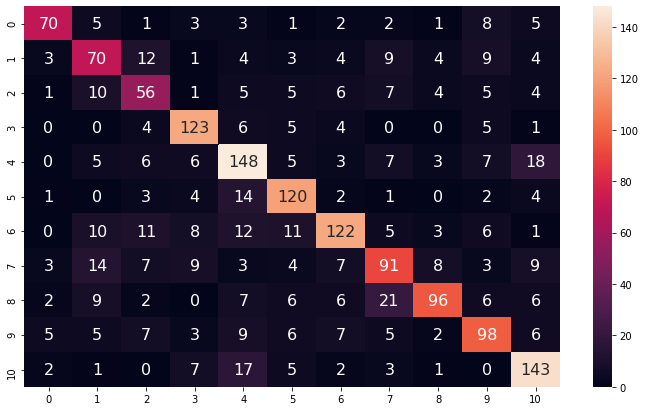

In [69]:
import seaborn as sn
print('Test accuracy:',accuracy)
print('')
print(classification_report(encoder.fit_transform(y_test), svm_predictions))
plt.figure(figsize=(12,7))
sn.heatmap(cm, annot=True, fmt="d", annot_kws={"size": 16})
plt.show()

### Transformation

To run, you need to install the following :

To apply the transformations to the support vectors, we first need to get the indices of the support vectors, then we need to match them to the true indices of the dataframe to get the filenames and so to apply the transformations to the songs.

In [45]:
#indices of the support vectors based on X_train
pipeline['m'].support_

array([  30,   34,   43, ..., 5005, 5006, 5015], dtype=int32)

In [46]:
#reset the X_train index to match the true indices to the support vectors indices
New = X_train.reset_index()
New

,index,mean,std,maxv,minv,median,skew,kurt,q1,q3,...,mfcc12,mfcc13,mfcc14,mfcc15,mfcc16,mfcc17,mfcc18,mfcc19,mfcc20,mfcc21
0,3443,5.716938,17.683928,549.234192,0.003726,0.945121,10.826470,187.774356,0.295527,4.180601,...,3.133055,6.392408,-0.978262,-4.387720,-2.911172,-0.504795,-1.426629,0.050133,-2.676947,1.334319
1,4633,8.385658,19.085619,586.054993,0.003697,3.327623,10.625385,186.586017,1.624239,8.201859,...,0.241745,6.341700,0.709961,3.437910,-4.734616,-1.594249,-7.103795,0.405623,-3.089756,0.461057
2,1261,2.166249,20.521887,1011.669617,0.004412,0.239641,30.143702,1129.412655,0.186696,0.572887,...,-14.324121,-19.905199,-15.350469,-14.838507,-9.745724,-1.960240,-2.769279,-0.077445,-2.108998,-8.618428
3,5139,9.161607,43.878048,1174.884155,0.004148,0.968162,13.859605,251.397293,0.323762,4.445615,...,9.417459,11.215713,6.239980,3.316119,-10.163992,-10.578778,-4.263647,8.393876,-2.376619,-25.484541
4,5213,5.925146,9.838175,149.094833,0.005401,3.038812,4.179233,25.384623,0.366418,6.578555,...,-13.519599,10.333515,1.887936,5.979057,-2.065614,-6.744569,10.112141,-17.720020,3.191033,-3.180895
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5023,4931,25.262371,44.674564,874.519409,0.003638,9.604394,5.468925,47.832265,4.614640,27.460431,...,-3.443966,-3.839472,-14.295295,-5.271041,-5.108438,-2.959980,-9.208304,3.693176,-2.927588,-5.278761
5024,3264,6.999949,25.748878,688.787231,0.000973,2.389395,12.544839,208.821031,1.333254,4.497228,...,-0.631808,1.834825,0.641515,2.943139,2.532608,2.443859,-4.293274,-1.627016,-3.373971,4.846880
5025,1653,0.816723,4.628470,395.633331,0.000062,0.086621,39.677872,2517.555525,0.039485,0.581596,...,-10.808010,-3.828719,-1.901184,-9.460688,-16.319187,-4.854747,-14.019266,-2.774554,-3.533316,-7.926543
5026,2607,19.230825,54.855324,2712.630615,0.011408,5.440352,13.895927,393.799364,2.813846,13.280812,...,-0.896797,5.934593,-6.928517,-0.567937,5.878472,12.049836,-5.192334,4.133560,6.268890,1.299922


In [47]:
#Get the true index of the support vectors
idx = New["index"][pipeline['m'].support_]

In [48]:
#Get the filenames related to the support vectors
df["filename"][idx]

96                [cel][pop_roc]0143__1.wav
313               [cel][jaz_blu]0012__2.wav
333                   [cel][cla]0079__1.wav
298               [cel][pop_roc]0062__1.wav
36                    [cel][cla]0113__1.wav
                       ...                 
6172              [voi][pop_roc]2352__2.wav
6654              [voi][pop_roc]2500__2.wav
6036              [voi][pop_roc]2339__2.wav
6216    142__[voi][dru][cou_fol]2430__3.wav
6458    056__[voi][dru][cou_fol]2403__3.wav
Name: filename, Length: 4774, dtype: object

Now that we have the songs that we want to transform, let's focus on the sound effects. The following three effects have been selected by the article :
- Reverberation
- Equalization
- Compression

In [49]:
# Import the package and create an audio effects chain function.
import pysndfx
from pysndfx import AudioEffectsChain

In [50]:
#the effects
fx = (
    AudioEffectsChain()
    .reverb()
    .equalizer(frequency=1000)
    .compand(attack=0.01,decay=1.0,
             soft_knee=10,threshold=-0.5, 
             db_from=-0.5, db_to=-0.5)
)

In [51]:
#An example of the effects on a song
y, sr = librosa.load(songname, mono=True, duration=30)
u = fx(y)
u

array([-0.02476388, -0.0066759 ,  0.10567182, ..., -0.06657755,
       -0.04636163,  0.05587816], dtype=float32)

We then extract the selected features from the transformed audio frames resulting in a new dataframe

In [52]:
header = 'filename mean std maxv minv median skew kurt q1 q3 mode iqr tempo pitch nb_peaks spectral_flatness spectral_slope spectral_spread poly_features tonnetz melspectrogram chroma_stft rmse cqt spectral_centroid spectral_bandwidth rolloff zero_crossing_rate'
for i in range(1, 22):
    header += f' mfcc{i}'
header += ' label'
header = header.split()

WARNING : DON'T RUN THIS CELL IF YOU ALREADY HAVE THE DATAFRAME

In [216]:
###### DON'T RUN THIS CELL IF YOU ALREADY HAVE THE DATAFRAME #######


file = open('data_3.csv', 'w', newline='')
with file:
    writer = csv.writer(file)
    writer.writerow(header)
instruments = 'cel cla flu gac gel org pia sax tru vio voi'.split() 
for i in instruments: 
    for filename in tqdm(os.listdir(f'/Users/selmabouchta/Downloads/IRMAS-TrainingData/{i}')):
        if filename in list(df["filename"][list(idx)]):
            songname = f'/Users/selmabouchta/Downloads/IRMAS-TrainingData/{i}/{filename}'
            u, sr = librosa.load(songname, mono=True, duration=30)
            y = fx(u)
            chroma_stft = librosa.feature.chroma_stft(y=y, sr=sr)
            rmse = librosa.feature.rms(y=y)
            cqt = librosa.cqt(y=y, sr=sr)
            spec_cent = librosa.feature.spectral_centroid(y=y, sr=sr)
            spec_cont = librosa.feature.spectral_contrast(y=y, sr=sr)
            spec_bw = librosa.feature.spectral_bandwidth(y=y, sr=sr)
            rolloff = librosa.feature.spectral_rolloff(y=y, sr=sr)
            zcr = librosa.feature.zero_crossing_rate(y)
            mfcc = librosa.feature.mfcc(y=y, sr=sr)
            spec_flat = librosa.feature.spectral_flatness(y=y)
            spec_slope = FeatureSpectralSlope(y,sr)
            spec_spread = FeatureSpectralSpread(y,sr)
            poly_feat = librosa.feature.poly_features(y=y, sr=sr)
            tonnetz = librosa.feature.tonnetz(y=y, sr=sr)
            mel = librosa.feature.melspectrogram(y=y, sr=sr)
            mean, std, maxv, minv, median, skew, kurt, q1, q3, mode, iqr = describe_freq(y)
            tempo = librosa.beat.tempo(y)[0]
            peaks = len(nb_peaks(y, hop_length = 256))
            autocorr = pitch(y,sr)
            to_append = f'{filename} {mean} {std} {maxv} {minv} {median} {skew} {kurt} {q1} {q3} {mode} {iqr} {tempo} {autocorr} {peaks} {np.mean(spec_flat)} {spec_slope} {spec_spread.item()} {np.mean(poly_feat)} {np.mean(tonnetz)} {np.mean(mel)} {np.mean(chroma_stft)} {np.mean(rmse)} {abs(np.mean(librosa.cqt(y=y, sr=sr)))} {np.mean(spec_cent)} {np.mean(spec_cent)} {np.mean(spec_bw)} {np.mean(rolloff)} {np.mean(zcr)}'    
        
            for e in mfcc:
                to_append += f' {np.mean(e)}'
        
            to_append += f' {i}'
            file = open('data_3.csv', 'a', newline='')
            with file:
                writer = csv.writer(file)
                writer.writerow(to_append.split())
    print('Instrument ', i, 'passed')

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:48: RuntimeWarning: invalid value encountered in sqrt
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:48: RuntimeWarning: invalid value encountered in sqrt
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:48: RuntimeWarning: invalid value encountered in sqrt
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:48: RuntimeWarning: invalid value encountered in sqrt
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:48: RuntimeWarning: invalid value encountered in sqrt
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:48: RuntimeWarning: invalid value encountered in sqrt
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:48: RuntimeWarning: invalid value encountered in sqrt
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:48: RuntimeWarning: invalid value encountered in sqrt
/opt/anaconda3/lib/python3.7/site-packages/ipyke

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:48: RuntimeWarning: invalid value encountered in sqrt
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:48: RuntimeWarning: invalid value encountered in sqrt
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:48: RuntimeWarning: invalid value encountered in sqrt
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:48: RuntimeWarning: invalid value encountered in sqrt
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:48: RuntimeWarning: invalid value encountered in sqrt
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:48: RuntimeWarning: invalid value encountered in sqrt
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:48: RuntimeWarning: invalid value encountered in sqrt
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:48: RuntimeWarning: invalid value encountered in sqrt



Instrument  cel passed


/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:48: RuntimeWarning: invalid value encountered in sqrt
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:48: RuntimeWarning: invalid value encountered in sqrt
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:48: RuntimeWarning: invalid value encountered in sqrt
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:48: RuntimeWarning: invalid value encountered in sqrt
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:48: RuntimeWarning: invalid value encountered in sqrt
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:48: RuntimeWarning: invalid value encountered in sqrt
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:48: RuntimeWarning: invalid value encountered in sqrt
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:48: RuntimeWarning: invalid value encountered in sqrt
/opt/anaconda3/lib/python3.7/site-packages/ipyke

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:48: RuntimeWarning: invalid value encountered in sqrt
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:48: RuntimeWarning: invalid value encountered in sqrt
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:48: RuntimeWarning: invalid value encountered in sqrt
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:48: RuntimeWarning: invalid value encountered in sqrt
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:48: RuntimeWarning: invalid value encountered in sqrt
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:48: RuntimeWarning: invalid value encountered in sqrt
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:48: RuntimeWarning: invalid value encountered in sqrt
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:48: RuntimeWarning: invalid value encountered in sqrt
/opt/anaconda3/lib/python3.7/site-packages/ipyke


Instrument  cla passed


/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:48: RuntimeWarning: invalid value encountered in sqrt
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:48: RuntimeWarning: invalid value encountered in sqrt
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:48: RuntimeWarning: invalid value encountered in sqrt
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:48: RuntimeWarning: invalid value encountered in sqrt
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:48: RuntimeWarning: invalid value encountered in sqrt
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:48: RuntimeWarning: invalid value encountered in sqrt
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:48: RuntimeWarning: invalid value encountered in sqrt
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:48: RuntimeWarning: invalid value encountered in sqrt
/opt/anaconda3/lib/python3.7/site-packages/ipyke

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:48: RuntimeWarning: invalid value encountered in sqrt
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:48: RuntimeWarning: invalid value encountered in sqrt
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:48: RuntimeWarning: invalid value encountered in sqrt
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:48: RuntimeWarning: invalid value encountered in sqrt
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:48: RuntimeWarning: invalid value encountered in sqrt
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:48: RuntimeWarning: invalid value encountered in sqrt
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:48: RuntimeWarning: invalid value encountered in sqrt
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:48: RuntimeWarning: invalid value encountered in sqrt
/opt/anaconda3/lib/python3.7/site-packages/ipyke


Instrument  flu passed


/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:48: RuntimeWarning: invalid value encountered in sqrt
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:48: RuntimeWarning: invalid value encountered in sqrt
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:48: RuntimeWarning: invalid value encountered in sqrt
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:48: RuntimeWarning: invalid value encountered in sqrt
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:48: RuntimeWarning: invalid value encountered in sqrt
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:48: RuntimeWarning: invalid value encountered in sqrt
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:48: RuntimeWarning: invalid value encountered in sqrt
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:48: RuntimeWarning: invalid value encountered in sqrt
/opt/anaconda3/lib/python3.7/site-packages/ipyke

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:48: RuntimeWarning: invalid value encountered in sqrt
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:48: RuntimeWarning: invalid value encountered in sqrt
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:48: RuntimeWarning: invalid value encountered in sqrt
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:48: RuntimeWarning: invalid value encountered in sqrt
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:48: RuntimeWarning: invalid value encountered in sqrt
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:48: RuntimeWarning: invalid value encountered in sqrt
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:48: RuntimeWarning: invalid value encountered in sqrt
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:48: RuntimeWarning: invalid value encountered in sqrt
/opt/anaconda3/lib/python3.7/site-packages/ipyke

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:48: RuntimeWarning: invalid value encountered in sqrt
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:48: RuntimeWarning: invalid value encountered in sqrt
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:48: RuntimeWarning: invalid value encountered in sqrt
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:48: RuntimeWarning: invalid value encountered in sqrt
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:48: RuntimeWarning: invalid value encountered in sqrt
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:48: RuntimeWarning: invalid value encountered in sqrt
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:48: RuntimeWarning: invalid value encountered in sqrt
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:48: RuntimeWarning: invalid value encountered in sqrt
/opt/anaconda3/lib/python3.7/site-packages/ipyke


Instrument  gac passed


/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:48: RuntimeWarning: invalid value encountered in sqrt
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:48: RuntimeWarning: invalid value encountered in sqrt
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:48: RuntimeWarning: invalid value encountered in sqrt
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:48: RuntimeWarning: invalid value encountered in sqrt
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:48: RuntimeWarning: invalid value encountered in sqrt
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:48: RuntimeWarning: invalid value encountered in sqrt
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:48: RuntimeWarning: invalid value encountered in sqrt
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:48: RuntimeWarning: invalid value encountered in sqrt
/opt/anaconda3/lib/python3.7/site-packages/ipyke

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:48: RuntimeWarning: invalid value encountered in sqrt
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:48: RuntimeWarning: invalid value encountered in sqrt
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:48: RuntimeWarning: invalid value encountered in sqrt
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:48: RuntimeWarning: invalid value encountered in sqrt
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:48: RuntimeWarning: invalid value encountered in sqrt
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:48: RuntimeWarning: invalid value encountered in sqrt
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:48: RuntimeWarning: invalid value encountered in sqrt
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:48: RuntimeWarning: invalid value encountered in sqrt
/opt/anaconda3/lib/python3.7/site-packages/ipyke

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:48: RuntimeWarning: invalid value encountered in sqrt
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:48: RuntimeWarning: invalid value encountered in sqrt
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:48: RuntimeWarning: invalid value encountered in sqrt
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:48: RuntimeWarning: invalid value encountered in sqrt
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:48: RuntimeWarning: invalid value encountered in sqrt
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:48: RuntimeWarning: invalid value encountered in sqrt
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:48: RuntimeWarning: invalid value encountered in sqrt
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:48: RuntimeWarning: invalid value encountered in sqrt
/opt/anaconda3/lib/python3.7/site-packages/ipyke


Instrument  gel passed


/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:48: RuntimeWarning: invalid value encountered in sqrt
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:48: RuntimeWarning: invalid value encountered in sqrt
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:48: RuntimeWarning: invalid value encountered in sqrt
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:48: RuntimeWarning: invalid value encountered in sqrt
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:48: RuntimeWarning: invalid value encountered in sqrt
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:48: RuntimeWarning: invalid value encountered in sqrt
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:48: RuntimeWarning: invalid value encountered in sqrt
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:48: RuntimeWarning: invalid value encountered in sqrt
/opt/anaconda3/lib/python3.7/site-packages/ipyke

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:48: RuntimeWarning: invalid value encountered in sqrt
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:48: RuntimeWarning: invalid value encountered in sqrt
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:48: RuntimeWarning: invalid value encountered in sqrt
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:48: RuntimeWarning: invalid value encountered in sqrt
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:48: RuntimeWarning: invalid value encountered in sqrt
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:48: RuntimeWarning: invalid value encountered in sqrt
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:48: RuntimeWarning: invalid value encountered in sqrt
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:48: RuntimeWarning: invalid value encountered in sqrt
/opt/anaconda3/lib/python3.7/site-packages/ipyke

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:48: RuntimeWarning: invalid value encountered in sqrt
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:48: RuntimeWarning: invalid value encountered in sqrt
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:48: RuntimeWarning: invalid value encountered in sqrt
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:48: RuntimeWarning: invalid value encountered in sqrt
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:48: RuntimeWarning: invalid value encountered in sqrt
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:48: RuntimeWarning: invalid value encountered in sqrt
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:48: RuntimeWarning: invalid value encountered in sqrt
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:48: RuntimeWarning: invalid value encountered in sqrt
/opt/anaconda3/lib/python3.7/site-packages/ipyke


Instrument  org passed


/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:48: RuntimeWarning: invalid value encountered in sqrt
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:48: RuntimeWarning: invalid value encountered in sqrt
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:48: RuntimeWarning: invalid value encountered in sqrt
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:48: RuntimeWarning: invalid value encountered in sqrt
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:48: RuntimeWarning: invalid value encountered in sqrt
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:48: RuntimeWarning: invalid value encountered in sqrt
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:48: RuntimeWarning: invalid value encountered in sqrt
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:48: RuntimeWarning: invalid value encountered in sqrt
/opt/anaconda3/lib/python3.7/site-packages/ipyke

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:48: RuntimeWarning: invalid value encountered in sqrt
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:48: RuntimeWarning: invalid value encountered in sqrt
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:48: RuntimeWarning: invalid value encountered in sqrt
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:48: RuntimeWarning: invalid value encountered in sqrt
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:48: RuntimeWarning: invalid value encountered in sqrt
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:48: RuntimeWarning: invalid value encountered in sqrt
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:48: RuntimeWarning: invalid value encountered in sqrt
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:48: RuntimeWarning: invalid value encountered in sqrt
/opt/anaconda3/lib/python3.7/site-packages/ipyke


Instrument  pia passed


/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:48: RuntimeWarning: invalid value encountered in sqrt
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:48: RuntimeWarning: invalid value encountered in sqrt
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:48: RuntimeWarning: invalid value encountered in sqrt
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:48: RuntimeWarning: invalid value encountered in sqrt
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:48: RuntimeWarning: invalid value encountered in sqrt
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:48: RuntimeWarning: invalid value encountered in sqrt
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:48: RuntimeWarning: invalid value encountered in sqrt
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:48: RuntimeWarning: invalid value encountered in sqrt
/opt/anaconda3/lib/python3.7/site-packages/ipyke

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:48: RuntimeWarning: invalid value encountered in sqrt
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:48: RuntimeWarning: invalid value encountered in sqrt
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:48: RuntimeWarning: invalid value encountered in sqrt
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:48: RuntimeWarning: invalid value encountered in sqrt
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:48: RuntimeWarning: invalid value encountered in sqrt
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:48: RuntimeWarning: invalid value encountered in sqrt
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:48: RuntimeWarning: invalid value encountered in sqrt
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:48: RuntimeWarning: invalid value encountered in sqrt
/opt/anaconda3/lib/python3.7/site-packages/ipyke


Instrument  sax passed


/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:48: RuntimeWarning: invalid value encountered in sqrt
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:48: RuntimeWarning: invalid value encountered in sqrt
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:48: RuntimeWarning: invalid value encountered in sqrt
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:48: RuntimeWarning: invalid value encountered in sqrt
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:48: RuntimeWarning: invalid value encountered in sqrt
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:48: RuntimeWarning: invalid value encountered in sqrt
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:48: RuntimeWarning: invalid value encountered in sqrt
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:48: RuntimeWarning: invalid value encountered in sqrt
/opt/anaconda3/lib/python3.7/site-packages/ipyke

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:48: RuntimeWarning: invalid value encountered in sqrt
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:48: RuntimeWarning: invalid value encountered in sqrt
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:48: RuntimeWarning: invalid value encountered in sqrt
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:48: RuntimeWarning: invalid value encountered in sqrt
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:48: RuntimeWarning: invalid value encountered in sqrt
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:48: RuntimeWarning: invalid value encountered in sqrt
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:48: RuntimeWarning: invalid value encountered in sqrt
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:48: RuntimeWarning: invalid value encountered in sqrt
/opt/anaconda3/lib/python3.7/site-packages/ipyke


Instrument  tru passed


/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:48: RuntimeWarning: invalid value encountered in sqrt
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:48: RuntimeWarning: invalid value encountered in sqrt
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:48: RuntimeWarning: invalid value encountered in sqrt
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:48: RuntimeWarning: invalid value encountered in sqrt
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:48: RuntimeWarning: invalid value encountered in sqrt
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:48: RuntimeWarning: invalid value encountered in sqrt
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:48: RuntimeWarning: invalid value encountered in sqrt
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:48: RuntimeWarning: invalid value encountered in sqrt
/opt/anaconda3/lib/python3.7/site-packages/ipyke

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:48: RuntimeWarning: invalid value encountered in sqrt
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:48: RuntimeWarning: invalid value encountered in sqrt
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:48: RuntimeWarning: invalid value encountered in sqrt
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:48: RuntimeWarning: invalid value encountered in sqrt
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:48: RuntimeWarning: invalid value encountered in sqrt
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:48: RuntimeWarning: invalid value encountered in sqrt
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:48: RuntimeWarning: invalid value encountered in sqrt
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:48: RuntimeWarning: invalid value encountered in sqrt
/opt/anaconda3/lib/python3.7/site-packages/ipyke


Instrument  vio passed


/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:48: RuntimeWarning: invalid value encountered in sqrt
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:48: RuntimeWarning: invalid value encountered in sqrt
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:48: RuntimeWarning: invalid value encountered in sqrt
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:48: RuntimeWarning: invalid value encountered in sqrt
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:48: RuntimeWarning: invalid value encountered in sqrt
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:48: RuntimeWarning: invalid value encountered in sqrt
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:48: RuntimeWarning: invalid value encountered in sqrt
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:48: RuntimeWarning: invalid value encountered in sqrt
/opt/anaconda3/lib/python3.7/site-packages/ipyke

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:48: RuntimeWarning: invalid value encountered in sqrt
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:48: RuntimeWarning: invalid value encountered in sqrt
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:48: RuntimeWarning: invalid value encountered in sqrt
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:48: RuntimeWarning: invalid value encountered in sqrt
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:48: RuntimeWarning: invalid value encountered in sqrt
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:48: RuntimeWarning: invalid value encountered in sqrt
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:48: RuntimeWarning: invalid value encountered in sqrt
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:48: RuntimeWarning: invalid value encountered in sqrt
/opt/anaconda3/lib/python3.7/site-packages/ipyke

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:48: RuntimeWarning: invalid value encountered in sqrt
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:48: RuntimeWarning: invalid value encountered in sqrt
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:48: RuntimeWarning: invalid value encountered in sqrt
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:48: RuntimeWarning: invalid value encountered in sqrt
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:48: RuntimeWarning: invalid value encountered in sqrt
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:48: RuntimeWarning: invalid value encountered in sqrt
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:48: RuntimeWarning: invalid value encountered in sqrt
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:48: RuntimeWarning: invalid value encountered in sqrt
/opt/anaconda3/lib/python3.7/site-packages/ipyke


Instrument  voi passed


### Paper contribution: VASVM

Import the dataset created by the previous cell

In [79]:
df2 = pd.read_csv('data_3.csv')

In [80]:
df2

,filename,mean,std,maxv,minv,median,skew,kurt,q1,q3,...,mfcc13,mfcc14,mfcc15,mfcc16,mfcc17,mfcc18,mfcc19,mfcc20,mfcc21,label
0,089__[cel][nod][cla]0026__3.wav,2.234447,7.644451,328.605743,0.000202,0.241308,13.131233,305.213433,0.055962,1.281898,...,-14.978279,-12.190589,-0.550249,5.827920,10.758458,13.596838,6.950404,-1.709820,-3.841307,cel
1,056__[cel][nod][cla]0038__2.wav,0.717094,2.551785,137.051758,0.000868,0.146149,17.525129,585.685523,0.059030,0.477212,...,9.445237,-7.427256,-5.495324,-8.431366,-3.418645,-6.967485,-0.351591,2.762719,7.957681,cel
2,013__[cel][nod][cla]0025__3.wav,3.012890,10.294704,447.922058,0.000178,0.346482,13.445481,314.125239,0.057469,2.220058,...,-9.825837,-3.316589,-7.888428,-8.273456,2.495920,4.380127,6.186677,11.873755,6.497957,cel
3,[cel][cla]0113__2.wav,0.181713,0.870906,28.980604,0.000118,0.020284,13.206199,250.806442,0.009628,0.058987,...,-2.137616,-5.297474,-8.242826,-17.180649,-1.960674,0.780064,7.380392,5.620405,9.419621,cel
4,[cel][cla]0125__3.wav,3.109123,12.520716,709.607727,0.001795,0.733097,25.882917,1048.230316,0.304165,2.221665,...,-0.981161,-12.522128,0.860737,-0.831170,-7.881251,-7.430367,14.134591,17.533745,33.809582,cel
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4769,[voi][jaz_blu]2491__3.wav,6.478651,23.936390,808.764709,0.003155,2.206625,18.521051,478.599809,1.185914,4.466237,...,1.440797,-3.685974,6.974942,-5.152614,-6.656729,-5.608459,-0.772770,-6.605496,-0.299701,voi
4770,[voi][pop_roc]2547__1.wav,13.001114,31.316090,994.725281,0.001351,5.139059,10.629542,190.539744,2.461622,12.021292,...,-0.679956,-2.487181,4.401832,1.984644,5.845368,-4.376061,2.103073,1.108675,-0.218506,voi
4771,[voi][pop_roc]2536__1.wav,36.927536,70.117447,2149.152832,0.014944,20.200014,10.304952,186.060952,10.969654,37.271642,...,6.330037,-2.747116,2.285870,-4.993823,-1.071156,-7.062100,4.449447,2.517378,6.965892,voi
4772,075__[voi][dru][pop_roc]2329__1.wav,28.192461,50.936672,1533.882202,0.016345,16.376062,9.482842,155.718642,8.920498,29.375767,...,-0.464113,-13.042430,0.868758,-6.889310,-3.533845,-8.312972,-3.446375,1.830793,5.852776,voi


Concatenate the two dataframes

In [81]:
result = pd.concat([df,df2]).reset_index(drop=True)
result

,filename,mean,std,maxv,minv,median,skew,kurt,q1,q3,...,mfcc13,mfcc14,mfcc15,mfcc16,mfcc17,mfcc18,mfcc19,mfcc20,mfcc21,label
0,089__[cel][nod][cla]0026__3.wav,2.388861,8.088955,281.472595,0.000445,0.242413,11.522677,220.398179,0.055017,1.334633,...,-13.709235,-10.900674,-0.081840,6.548846,10.592492,13.113258,5.991782,-1.813061,-3.287689,cel
1,[cel][pop_roc]0096__2.wav,27.919312,69.527596,2296.462646,0.016606,9.328909,13.786602,291.555426,3.609649,30.335614,...,-2.962942,-6.110078,6.559651,-9.423152,5.922300,-7.209832,0.299793,-4.530111,-3.739530,cel
2,056__[cel][nod][cla]0038__2.wav,0.790885,3.137241,160.559662,0.000767,0.148365,19.250458,631.382243,0.059151,0.492508,...,6.881845,-7.868127,-4.319943,-7.773156,-3.717960,-6.400105,-0.923082,3.473801,7.782931,cel
3,013__[cel][nod][cla]0025__3.wav,3.318427,12.325465,532.957458,0.000164,0.351867,14.129045,324.414721,0.058642,2.338600,...,-9.674383,-2.450662,-8.507931,-5.893132,2.722776,5.479173,5.307874,11.341611,5.198703,cel
4,[cel][pop_roc]0014__1.wav,2.966229,16.072098,1014.245300,0.000693,0.162598,22.239227,842.027234,0.069372,1.155499,...,-17.367170,-15.911999,-8.282969,-1.484040,-6.186651,-8.048862,-6.806072,-7.740180,-6.521208,cel
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11474,[voi][jaz_blu]2491__3.wav,6.478651,23.936390,808.764709,0.003155,2.206625,18.521051,478.599809,1.185914,4.466237,...,1.440797,-3.685974,6.974942,-5.152614,-6.656729,-5.608459,-0.772770,-6.605496,-0.299701,voi
11475,[voi][pop_roc]2547__1.wav,13.001114,31.316090,994.725281,0.001351,5.139059,10.629542,190.539744,2.461622,12.021292,...,-0.679956,-2.487181,4.401832,1.984644,5.845368,-4.376061,2.103073,1.108675,-0.218506,voi
11476,[voi][pop_roc]2536__1.wav,36.927536,70.117447,2149.152832,0.014944,20.200014,10.304952,186.060952,10.969654,37.271642,...,6.330037,-2.747116,2.285870,-4.993823,-1.071156,-7.062100,4.449447,2.517378,6.965892,voi
11477,075__[voi][dru][pop_roc]2329__1.wav,28.192461,50.936672,1533.882202,0.016345,16.376062,9.482842,155.718642,8.920498,29.375767,...,-0.464113,-13.042430,0.868758,-6.889310,-3.533845,-8.312972,-3.446375,1.830793,5.852776,voi


Re-train the SVMs using the original feature vectors X plus all the virtual ones in $\hat{S}$ created using all the effects. We first test our algorithm on the same test base than the first SVM in order to compare them properly.

In [82]:
encoder = LabelEncoder()
scaler = StandardScaler()

#defining X (features) and y (label)
X = result.loc[:, (result.columns != 'label') & (result.columns != 'filename') & (result.columns != 'spectral_spread')]
y = encoder.fit_transform(result['label'])

#dividing X, y into train and test data: 
# as we use the first SVM test data, 
# we do not care about the test split
X_train, X_test, _, _ = train_test_split(X, y, random_state=0)

# training a linear SVM classifier
svm_model = SVC(kernel = 'rbf', C = 1000, gamma=0.05)

pipeline = Pipeline(steps=[('t', scaler), ('m', svm_model)])
pipeline.fit(X_train,y_train)
svm_predictions = pipeline.predict(X_test_)
  
# model accuracy for X_test  
accuracy = pipeline.score(X_test_, y_test_)
  
# creating a confusion matrix
cm = confusion_matrix(y_test_, svm_predictions)

Test accuracy: 0.8998211091234347

              precision    recall  f1-score   support

           0       0.92      0.85      0.89       101
           1       0.88      0.83      0.85       123
           2       0.80      0.87      0.83       104
           3       0.92      0.95      0.93       148
           4       0.85      0.90      0.87       208
           5       0.92      0.89      0.91       151
           6       0.93      0.89      0.91       189
           7       0.87      0.90      0.88       158
           8       0.94      0.93      0.93       161
           9       0.93      0.90      0.92       153
          10       0.92      0.94      0.93       181

    accuracy                           0.90      1677
   macro avg       0.90      0.90      0.90      1677
weighted avg       0.90      0.90      0.90      1677



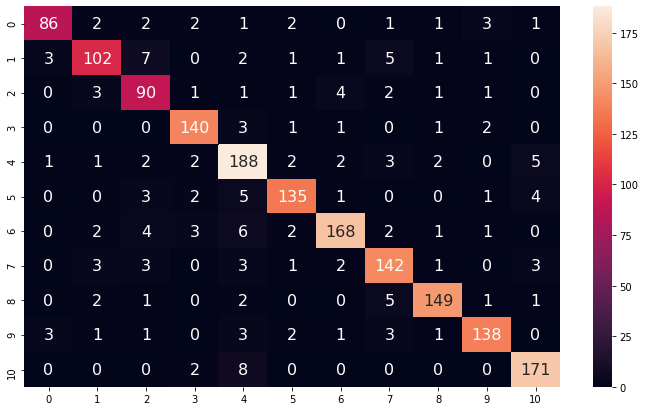

In [84]:
print('Test accuracy:',accuracy)
print('')
print(classification_report(encoder.fit_transform(y_test_), svm_predictions))
plt.figure(figsize=(12,7))
sn.heatmap(cm, annot=True, fmt="d", annot_kws={"size": 16})
plt.show()

We can see that the score got way better with the second training. We know test on a larger test base, using the train test split on the new database created.

Test accuracy: 0.8644599303135888

              precision    recall  f1-score   support

           0       0.93      0.81      0.87       176
           1       0.85      0.84      0.85       204
           2       0.78      0.86      0.82       172
           3       0.85      0.92      0.89       244
           4       0.80      0.89      0.85       338
           5       0.88      0.89      0.88       305
           6       0.90      0.86      0.88       320
           7       0.87      0.80      0.83       302
           8       0.88      0.86      0.87       224
           9       0.87      0.83      0.85       246
          10       0.89      0.91      0.90       339

    accuracy                           0.86      2870
   macro avg       0.87      0.86      0.86      2870
weighted avg       0.87      0.86      0.86      2870



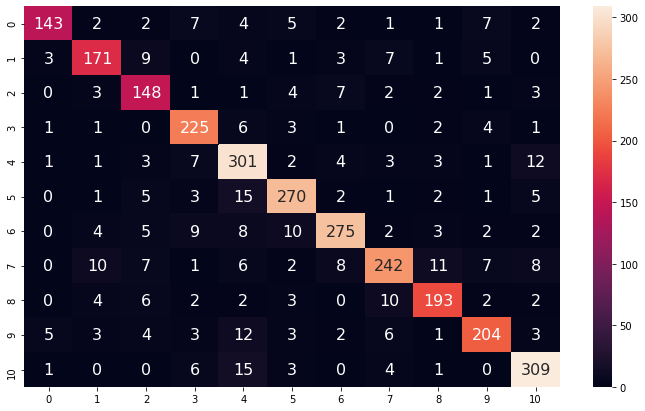

In [86]:
encoder = LabelEncoder()
scaler = StandardScaler()

#defining X (features) and y (label)
X = result.loc[:, (result.columns != 'label') & (result.columns != 'filename') & (result.columns != 'spectral_spread')]
y = encoder.fit_transform(result['label'])

#dividing X, y into train and test data
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=0)

# training a linear SVM classifier
svm_model = SVC(kernel = 'rbf', C = 1000, gamma=0.05)

pipeline = Pipeline(steps=[('t', scaler), ('m', svm_model)])
pipeline.fit(X_train,y_train)
svm_predictions = pipeline.predict(X_test)
  
# model accuracy for X_test  
accuracy = pipeline.score(X_test, y_test)
  
# creating a confusion matrix
cm = confusion_matrix(y_test, svm_predictions)

print('Test accuracy:',accuracy)
print('')
print(classification_report(encoder.fit_transform(y_test), svm_predictions))
plt.figure(figsize=(12,7))
sn.heatmap(cm, annot=True, fmt="d", annot_kws={"size": 16})
plt.show()